# 1 加载CIFAR10数据集

电商18 180412126 王佳琦

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])#数据集加载时，默认的图片格式是 numpy，所以通过 transforms 转换成 Tensor。
                                                              #然后，再对输入图片进行标准化。
    #前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，Normalize对每个通道执行以下操作：image =（图像-平均值）/ std

batch_size = 4

#batchsize: 批大小 num_works:num_works: 是否多进程读取数据 shuffle: 每个 epoch 是否乱序 drop_last: 当样本数不能被 batchsize 整除时，是否舍弃最后一批数据

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img*0.5 + 0.5     # unnormalize  还原被归一化的数据
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    #在pytorch中张量tensor对图象的存储是(b,c,w,h)分别表示(图片数量，通道数，图片高，图片宽)。

                                                    #单独说tensor中的某张图片，也就是(管道数，宽，高)。而标准的rbg图象是(宽，高，管道数)。
    plt.show()

ship


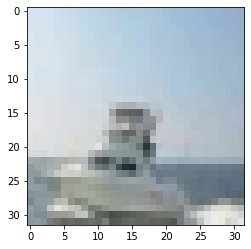

8
tensor([[[0.6706, 0.6549, 0.6549,  ..., 0.1843, 0.1843, 0.1686],
         [0.6784, 0.6627, 0.6627,  ..., 0.1922, 0.1922, 0.1843],
         [0.6941, 0.6784, 0.6706,  ..., 0.2000, 0.2000, 0.1843],
         ...,
         [0.1373, 0.0667, 0.1216,  ..., 0.6941, 0.5373, 0.4353],
         [0.0902, 0.0118, 0.0118,  ..., 0.7804, 0.7490, 0.6392],
         [0.0745, 0.1216, 0.0667,  ..., 0.6392, 0.7020, 0.7882]],

        [[0.7961, 0.7804, 0.7804,  ..., 0.3647, 0.3647, 0.3490],
         [0.7961, 0.7804, 0.7804,  ..., 0.3725, 0.3725, 0.3647],
         [0.7961, 0.7804, 0.7804,  ..., 0.3804, 0.3804, 0.3647],
         ...,
         [0.2471, 0.1608, 0.1922,  ..., 0.7020, 0.5451, 0.4353],
         [0.2000, 0.1137, 0.0902,  ..., 0.7882, 0.7569, 0.6392],
         [0.1922, 0.2157, 0.1373,  ..., 0.6392, 0.7020, 0.7882]],

        [[0.8980, 0.8824, 0.8824,  ..., 0.6157, 0.6157, 0.6000],
         [0.8902, 0.8745, 0.8745,  ..., 0.6235, 0.6235, 0.6078],
         [0.8745, 0.8588, 0.8588,  ..., 0.6157, 0.6157, 

In [8]:
(data,label)=trainset[100]
print(classes[label])
imshow(data)
print(label)
print(data)

In [6]:
# get some random training images
dataiter = iter(trainloader)    #可迭代的对象
images, labels = dataiter.next()  #相当于list里的取第几个，此处每次都会被打乱，所以是随机的四张图。


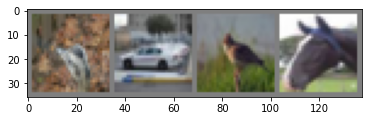

In [7]:
# show images
imshow(torchvision.utils.make_grid(images))

In [8]:
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

 bird   car  bird horse


# 2 通过简单卷积神经网络识别图像

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)             #定义卷积层和池化层
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)       #定义全连接层
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [13]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()         #用交叉熵作loss function
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)  #随机梯度下降法

In [14]:
from visdom import Visdom
visdom_show = Visdom(env="loss")
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data          

        # zero the parameter gradients
        optimizer.zero_grad()       #梯度从零开始

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            visdom_show.line(
            X=[12000*epoch+i+1],
            Y=[float(running_loss / 2000)],
            win='loss',
            name='train_loss with normalization',
            opts=dict(title='loss', legend=['train_loss with normalization']),
            update='append')
            running_loss = 0.0

print('Finished Training')

Setting up a new session...


[1,  2000] loss: 2.201
[1,  4000] loss: 1.870
[1,  6000] loss: 1.687
[1,  8000] loss: 1.555
[1, 10000] loss: 1.497
[1, 12000] loss: 1.428
[2,  2000] loss: 1.390
[2,  4000] loss: 1.336
[2,  6000] loss: 1.324
[2,  8000] loss: 1.287
[2, 10000] loss: 1.286
[2, 12000] loss: 1.284
[3,  2000] loss: 1.198
[3,  4000] loss: 1.191
[3,  6000] loss: 1.186
[3,  8000] loss: 1.182
[3, 10000] loss: 1.156
[3, 12000] loss: 1.151
[4,  2000] loss: 1.083
[4,  4000] loss: 1.081
[4,  6000] loss: 1.090
[4,  8000] loss: 1.094
[4, 10000] loss: 1.090
[4, 12000] loss: 1.090
Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

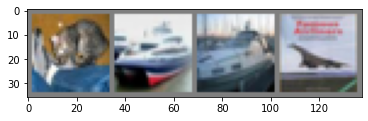

GroundTruth:    cat  ship  ship plane


In [17]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [18]:
outputs = net(images)

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car truck plane


In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)        #放进模型里
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()  #相同的累加

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 59 %


In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}  #定义列表
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 70.9 %
Accuracy for class car   is: 70.4 %
Accuracy for class bird  is: 31.4 %
Accuracy for class cat   is: 33.4 %
Accuracy for class deer  is: 54.9 %
Accuracy for class dog   is: 55.1 %
Accuracy for class frog  is: 79.6 %
Accuracy for class horse is: 64.7 %
Accuracy for class ship  is: 59.9 %
Accuracy for class truck is: 78.4 %


[WinError 10054] 远程主机强迫关闭了一个现有的连接。
[WinError 10054] 远程主机强迫关闭了一个现有的连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10054] 远程主机强迫关闭了一个现有的连接。
[WinError 10054] 远程主机强迫关闭了一个现有的连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
[WinError 10061] 由于目标计算机积极拒绝，无法连接。
